# Single channel receiver / Double channel transmitter example

In [1]:
! bladeRF-cli -p


  Description:    Nuand bladeRF 2.0
  Backend:        libusb
  Serial:         eb56038a9b0d4ccdace93a3476002277
  USB Bus:        2
  USB Address:    3



In [2]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (16, 8)

In [3]:
import numpy as np
from numpy.fft import fft, fftshift, fftfreq

In [4]:
import pyblade

In [5]:
# Step 1: generate test signal

from helpers.filter_ import lpf

In [6]:
def norm(s_t):
    m = max(np.abs(s_t.real).max(), np.abs(s_t.imag).max())
    return s_t / m

In [7]:
t_s = 1. / (4 * 1024 * 1024)
bandwidth_ = 2 * 1024 * 1024

n = 1_000_000

t = np.arange(n) * t_s

# s1_t = np.random.gamma(2, size=n)
s1_t = np.random.normal(size=n)
s2_t = np.random.normal(size=n)

s1_t = lpf(s1_t, t_s, f_cutoff=.05 * bandwidth_, order=6)
s2_t = lpf(s2_t, t_s, f_cutoff=.05 * bandwidth_, order=2)  # NOTE: different filter order

s1_central = bandwidth_ / 2 * .5
s2_central = bandwidth_ / 2 * 1

s1_t = s1_t * np.exp(+ 1j * 2 * np.pi * s1_central * t)
s1_t = norm(s1_t) * .7  # NOTE: factor

s2_t = s2_t * np.exp(+ 1j * 2 * np.pi * s2_central * t)
s2_t = norm(s2_t)

s1_f = fft(s1_t)
s1_f = fftshift(s1_f)

s2_f = fft(s2_t)
s2_f = fftshift(s2_f)

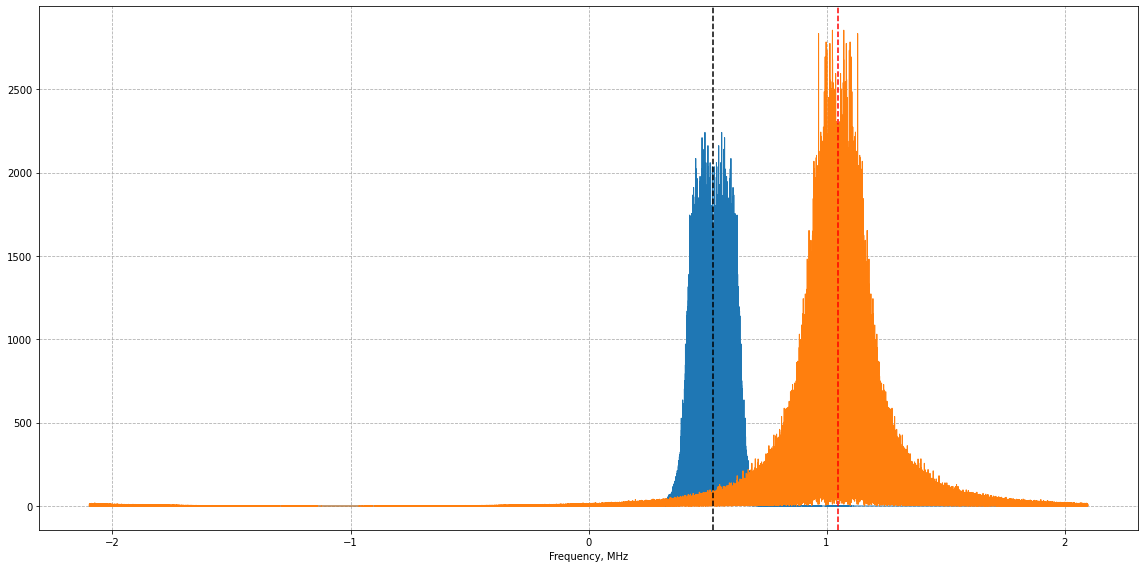

In [8]:
f = (fftfreq(len(s1_t), t_s)) * 1e-6
f = fftshift(f)

fig, axis = plt.subplots()

axis.plot(f, np.abs(s1_f), linewidth=1)
axis.plot(f, np.abs(s2_f), linewidth=1)

# Add two vertical lines to emphisize central frequencies:
axis.axvline(s1_central * 1e-6, color='black', linestyle='--')
axis.axvline(s2_central * 1e-6, color='red', linestyle='--')

axis.grid(visible=True, which='major', linestyle='--')
axis.set_xlabel('Frequency, MHz')

fig.tight_layout()

In [9]:
rx_config = pyblade.RxConfig(samplerate='4M',
                             frequency=434e6,
                             bandwidth='2M',
                             n_samples='1M',
                             agc=None,
                             channels=(1, ))

tx_frequency_offset = -1e6
tx_frequency = rx_config.frequency + tx_frequency_offset

In [10]:
tx_config = pyblade.TxConfig(samplerate=rx_config.samplerate,
                             frequency=tx_frequency,
                             bandwidth=rx_config.bandwidth,
                             channels=(1, 2),
                             signals_t=[s1_t, s2_t])

iq = pyblade.run(rx_config=rx_config,
                 tx_config=tx_config,
                 scenario=(
                                 'tx start',
                                 'rx start',
                                 'rx',
                                 'tx',
                                 'rx wait',
                                 # 'rx stop',
                                 # 'tx stop',
                            ))

Executing bladeRF-cli with:
 set samplerate rx1 4M
set frequency rx1 434000000.0
set bandwidth rx1 2M
set agc on
rx config file=/tmp/tmpys0935u6 channel=1 n=1M
set samplerate tx1 4M
set frequency tx1 433000000.0
set bandwidth tx1 2M
set samplerate tx2 4M
set frequency tx2 433000000.0
set bandwidth tx2 2M
tx config file=/tmp/tmptrwu_bl4 channel=1,2 format=bin repeat=0
tx start
rx start
rx
tx
rx wait
bladeRF-cli output is:   Setting RX1 sample rate - req:   4000000 0/1Hz, actual:   4000000 0/1Hz
  RX1 Frequency:  433999998 Hz (Range: [70000000, 6000000000])
  RX1 Bandwidth:   2000000 Hz (Range: [200000, 56000000])
  RX1 AGC: Enabled   
  RX2 AGC: Enabled   
  Setting TX1 sample rate - req:   4000000 0/1Hz, actual:   4000000 0/1Hz
  TX1 Frequency:  433000000 Hz (Range: [47000000, 6000000000])
  TX1 Bandwidth:   2000000 Hz (Range: [200000, 56000000])
  Setting TX2 sample rate - req:   4000000 0/1Hz, actual:   4000000 0/1Hz
  TX2 Frequency:  433000000 Hz (Range: [47000000, 6000000000])
  TX

In [11]:
iq.shape

(1, 1048576)

In [12]:
x_t = iq[0, ]
x_t.shape

(1048576,)

In [13]:
from scipy import signal

In [14]:
# The expected signal is a mixture of s_1 and s_2

e_t = s1_t + s2_t

e_f = fft(e_t)
e_f = fftshift(e_f)

f_model = (fftfreq(len(e_t), t_s) + tx_config.frequency_) * 1e-6
f_model = fftshift(f_model)

f_welch, Pee_den = signal.welch(e_t, 1. / t_s, nperseg=1024, return_onesided=False)

f_welch += tx_config.frequency_
f_welch *= 1e-6

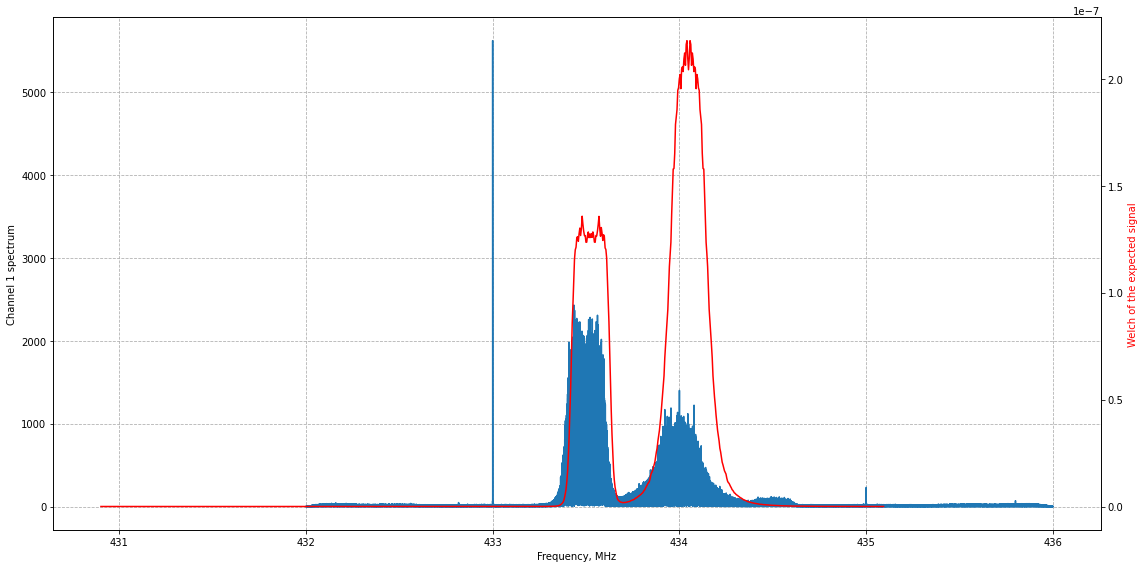

In [15]:
t_s = 1. / rx_config.samplerate_

f = (fftfreq(len(x_t), d=t_s) + rx_config.frequency_) * 1e-6
f = fftshift(f)

x_f = fftshift(fft(x_t))

fig, axis_x = plt.subplots(nrows=1)

axis_welch = axis_x.twinx()

axis_x.plot(f, np.abs(x_f))
axis_welch.plot(fftshift(f_welch), fftshift(Pee_den), color='red')

# axis_x.plot(f_model, np.abs(e_f), alpha=.3)

axis_x.set_xlabel('Frequency, MHz')
axis_x.set_ylabel('Channel 1 spectrum')
axis_welch.set_ylabel('Welch of the expected signal', color='red')
axis_x.grid(visible=True, which='major', linestyle='--')

fig.tight_layout()